In [1]:
from datetime import datetime
import os
import re

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from ipynb.fs.defs.functions import prep_data, train, break_out_solution
from models.single_head_single_class.model import SingleHeadSingleClass
from models.single_head_multi_class.model import SingleHeadMultiClass
from models.multi_head_model.model import MultiHeadModel
from models.testing.model import Model

# Setup rng
torch.manual_seed(42)
np.random.seed(42)

In [2]:
model_type = Model

In [3]:
# Check cuda is available and if so, set DEVICE to use gpu device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# Load images and labels
data = pd.read_csv("data/unzipped/training_solutions_rev1.csv")

In [5]:
# Create train, test, and validation sets
train_dataset, test_dataset, val_dataset = prep_data(data)

## Training

In [6]:
# Load the model
model_name = "sander"
model_path = "models/model/saved/"
model = model_type().to(DEVICE)
model.load_state_dict(torch.load(model_path + model_name + ".pth", weights_only=True, map_location=DEVICE))

<All keys matched successfully>

In [7]:
# Training Parameters
EPOCHS = 1000
BATCH_SIZE = 64
LR = 0.0004
GAMMA = 0.99

# Create a loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Competition requested MSE loss
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

# Save path
model_name = model_name + f"_continued_lr{LR}_gamma{GAMMA}"
save_path = model_path

In [8]:
print(f"Save path: {save_path}")

Save path: models/model/saved/


In [9]:
# Run a single image through the model
model_output = model(train_dataset.tensors[0][0].unsqueeze(0))
print(f"Model output shape: {model_output.shape}")

Model output shape: torch.Size([1, 37])


In [10]:
# Create a data loader for the training data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create a data loader for the test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
# Train the model
train_loss, test_loss = train(model, EPOCHS, train_loader, test_loader, optimizer, scheduler, criterion)

11/24 15:31:21 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 15.538945	Test Loss: 14.463319
11/24 15:31:25 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 15.538297	Test Loss: 14.464228
11/24 15:31:29 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 15.535796	Test Loss: 14.464289
11/24 15:31:32 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 15.538493	Test Loss: 14.463860
11/24 15:31:36 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 15.539501	Test Loss: 14.462575
11/24 15:31:39 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 15.538636	Test Loss: 14.463265
11/24 15:31:43 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 15.536428	Test Loss: 14.464827
11/24 15:31:46 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 15.542978	Test Loss: 14.464646
11/24 15:31:50 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 15.542246	Test Loss: 14.464772
11/24 15:31:53 Train Epoch:   10 [49262/49262 (100%)]	Train Loss: 15.538046	Test Loss: 14.463340
11/24 15:31:57 Train Epoch:   

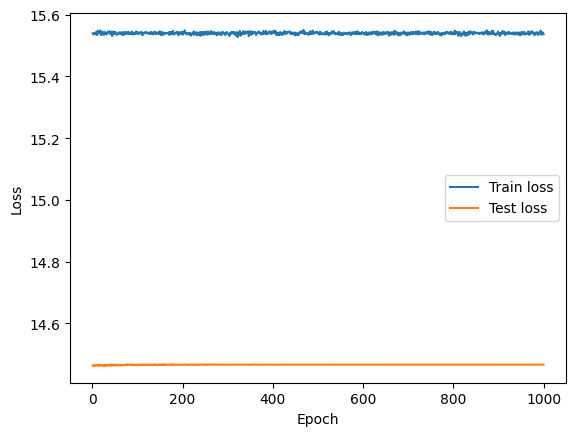

In [12]:
# Plot losses
plt.plot(range(1, EPOCHS + 1), train_loss, label="Train loss")
plt.plot(range(1, EPOCHS + 1), test_loss, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

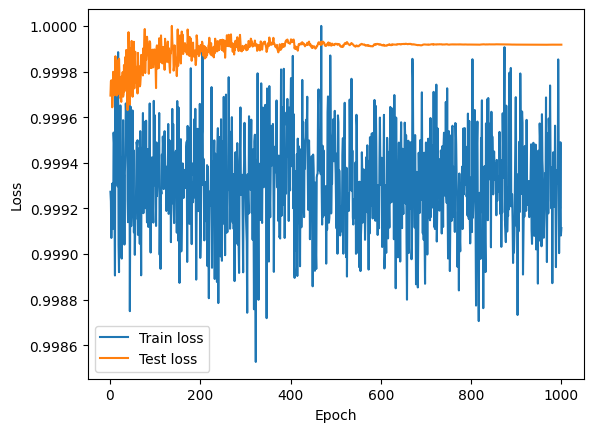

In [13]:
# Plot normalized losses
plt.plot(range(1, EPOCHS + 1), np.array(train_loss) / np.max(train_loss), label="Train loss")
plt.plot(range(1, EPOCHS + 1), np.array(test_loss) / np.max(test_loss), label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
# New model
if model_name is None:
    model_name = f"{datetime.now().strftime('%y%m%d%H%M%S')}_model_{model.__class__.__name__}_E{EPOCHS}_B{BATCH_SIZE}_LR{LR}_GAMMA{GAMMA}_TRAIN{train_loss[-1]:.4f}_TEST{test_loss[-1]:.4f}.pth"

In [15]:
# Save the model
if not os.path.exists(save_path):
    os.makedirs(save_path)
torch.save(model.state_dict(), save_path + model_name + ".pth")
print(f"Model saved as {model_name}")

# Save the losses
np.save(save_path + model_name + "_loss.npy", np.array([train_loss, test_loss]))

Model saved as sander_continued_lr0.0004_gamma0.99


## Evaluation

In [16]:
# Evaluation Metrics
model.eval()

# Eval Size
eval_size = 1000

true_labels = break_out_solution(test_dataset.tensors[1][:eval_size])
pred_labels = break_out_solution(model(test_dataset.tensors[0][:eval_size]))

# Calculate evaluation metrics
for i in range(len(true_labels)):
    print(f"Class {i + 1}:")
    print(f"Accuracy: {accuracy_score(true_labels[i], pred_labels[i])}")
    print(f"Precision: {precision_score(true_labels[i], pred_labels[i], average='macro')}")
    print(f"Recall: {recall_score(true_labels[i], pred_labels[i], average='macro')}")
    print(f"F1 Score: {f1_score(true_labels[i], pred_labels[i], average='macro')}")
    print()

Class 1:
Accuracy: 0.81
Precision: 0.5367061063511492
Recall: 0.5381720562587442
F1 Score: 0.5374058747525353

Class 2:
Accuracy: 0.983
Precision: 0.5
Recall: 0.4915
F1 Score: 0.4957135653050933

Class 3:
Accuracy: 0.823
Precision: 0.704354926510615
Recall: 0.6859594198303876
F1 Score: 0.6941943576267409

Class 4:
Accuracy: 0.89
Precision: 0.6663043478260869
Recall: 0.6437226997322812
F1 Score: 0.6537875640493007

Class 5:
Accuracy: 0.593
Precision: 0.48269602384878985
Recall: 0.45683046157193385
F1 Score: 0.45769115454926673

Class 6:
Accuracy: 0.973
Precision: 0.8314018992435217
Recall: 0.6880708805261235
F1 Score: 0.7383492746460447

Class 7:
Accuracy: 0.863
Precision: 0.8005672185696882
Recall: 0.7663843456836918
F1 Score: 0.7803059535020682

Class 8:
Accuracy: 0.452
Precision: 0.377811620551015
Recall: 0.3429688823448499
F1 Score: 0.33458776519831124

Class 9:
Accuracy: 0.53
Precision: 0.5483520983851053
Recall: 0.5921977131665719
F1 Score: 0.4844563079998732

Class 10:
Accuracy: 

c:\Users\ethan\school\MSAAI\AAI 521\final_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ethan\school\MSAAI\AAI 521\final_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ethan\school\MSAAI\AAI 521\final_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

Class 1:


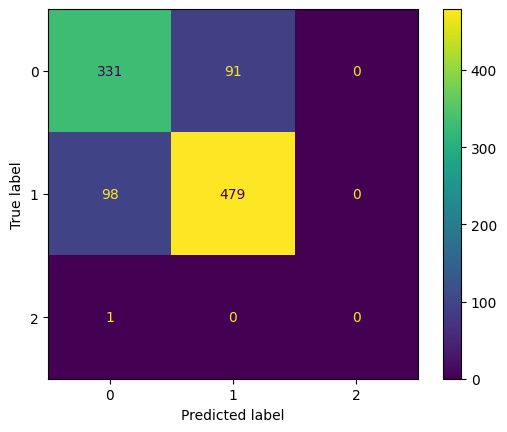


Class 2:


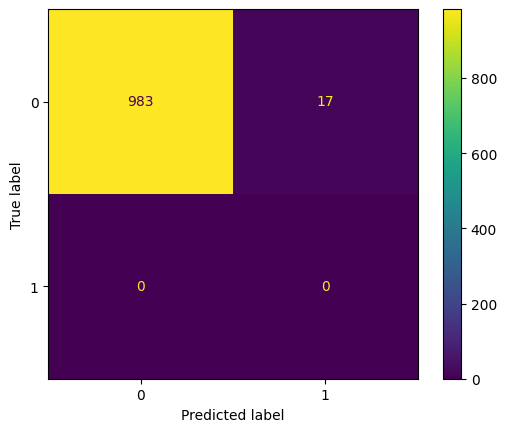


Class 3:


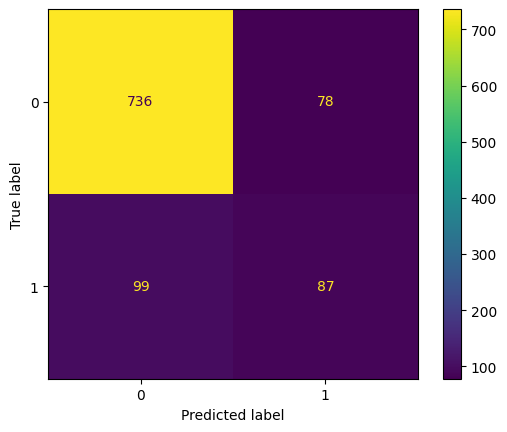


Class 4:


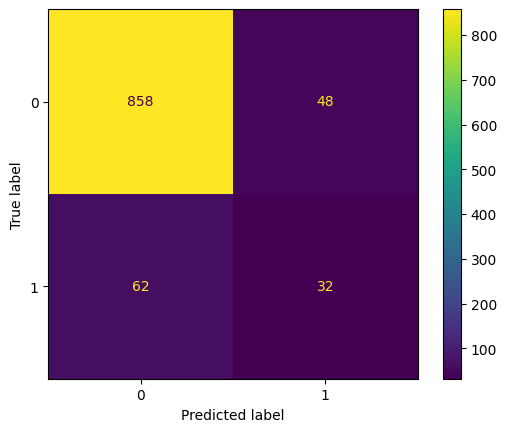


Class 5:


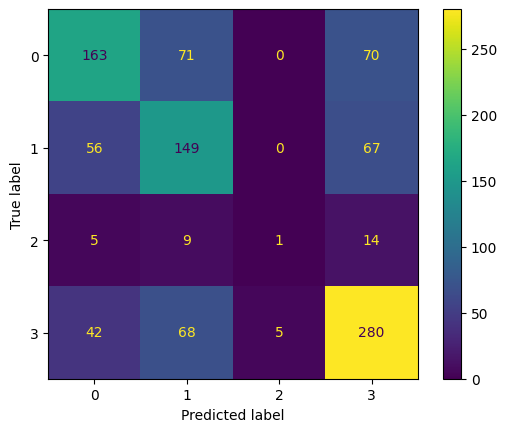


Class 6:


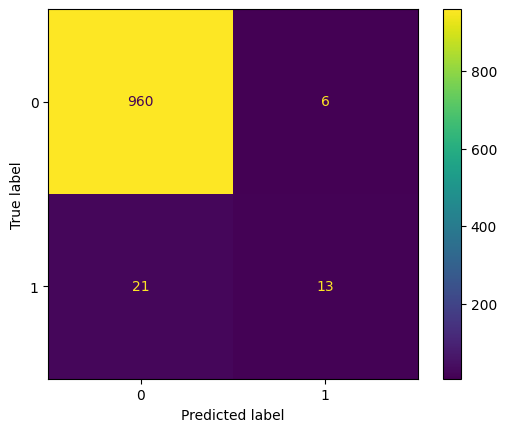


Class 7:


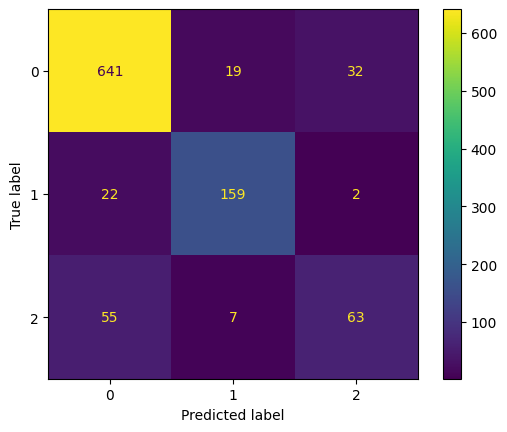


Class 8:


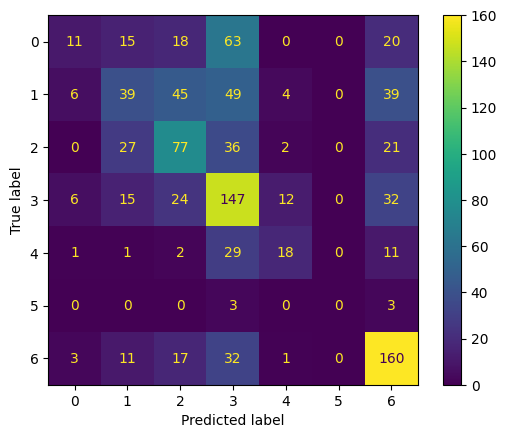


Class 9:


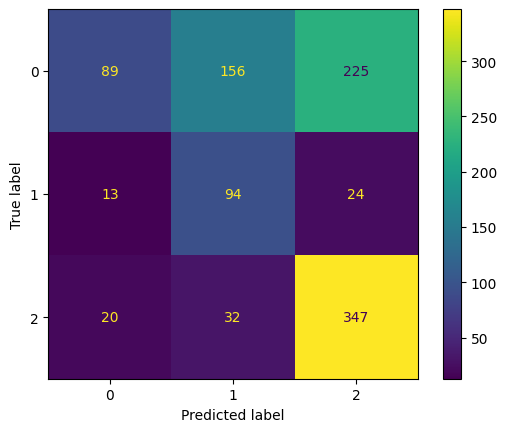


Class 10:


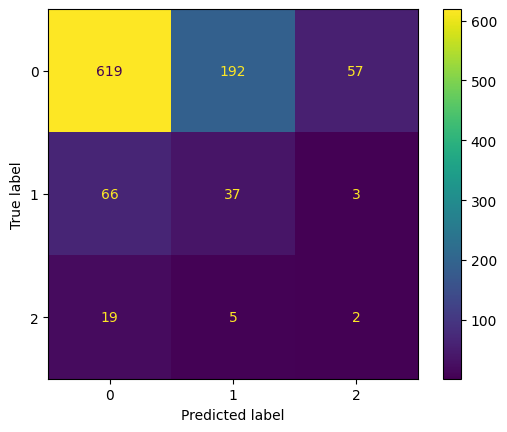


Class 11:


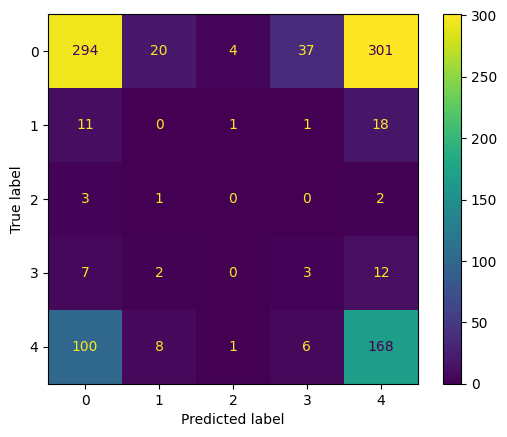

In [17]:
# Display confusion matrices in pretty format
for i in range(len(true_labels)):
    print(f"Class {i + 1}:")
    cm = confusion_matrix(true_labels[i], pred_labels[i])
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()
    print()
